# Chapter 4

In [1]:
import scipy.stats as stats
from seaborn import kdeplot, histplot
from numpy import prod, log, mean, linspace, std
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az

In [2]:
prod([2,3,4])

24

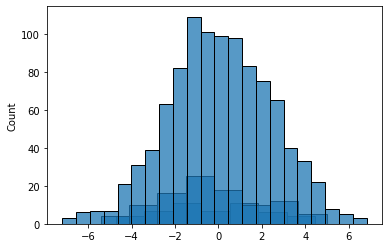

In [3]:
steps=16
for participants in (50,100,1000):
    histplot([sum(stats.uniform(-1,2).rvs(steps)) for x in range(0,participants)])

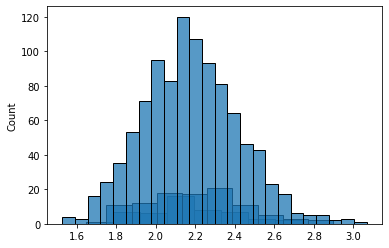

In [4]:
for participants in (50,100,1000):
    histplot([prod(stats.uniform(1.0,0.1).rvs(steps)) for x in range(0,participants)])

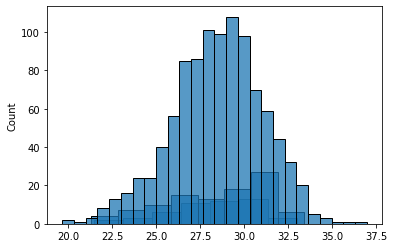

In [5]:
for participants in (50,100,1000):
    histplot([log(prod(stats.uniform(1.0,12).rvs(steps))) for x in range(0,participants)])

Gaussian distribution -> most of it mass 1 std from mean, thin tales. That is an assumption that could be a problem in some cases.

In [6]:
howell1 = pd.read_csv('./data/howell1.csv', sep=';') 

Text(0, 0.5, 'height')

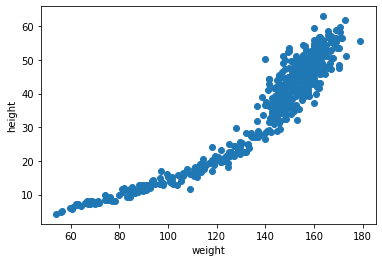

In [7]:
plt.plot(howell1['height'], howell1['weight'], 'o')
plt.xlabel('weight')
plt.ylabel('height')

In [8]:
adults = howell1[howell1['age']>18]

Text(0, 0.5, 'height')

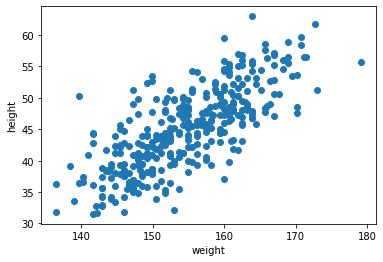

In [9]:
plt.plot(adults['height'], adults['weight'], 'o')
plt.xlabel('weight')
plt.ylabel('height')

(array([ 8., 31., 61., 59., 62., 65., 35., 18.,  6.,  1.]),
 array([136.525 , 140.7795, 145.034 , 149.2885, 153.543 , 157.7975,
        162.052 , 166.3065, 170.561 , 174.8155, 179.07  ]),
 <BarContainer object of 10 artists>)

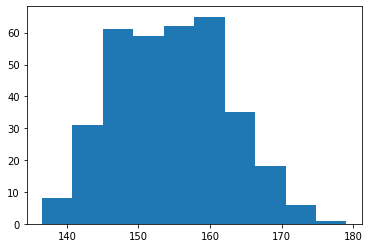

In [10]:
plt.hist(adults['height'])

Overthinking: IID as an epistemological, not ontological assumption.

Let's fit a gaussian distribution to heights.

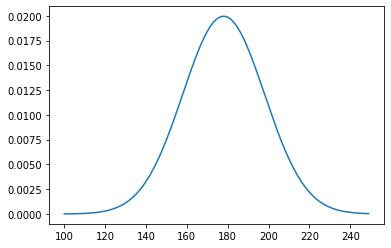

In [11]:
plt.plot(range(100,250),[stats.norm(178,20).pdf(x) for x in range(100,250)])

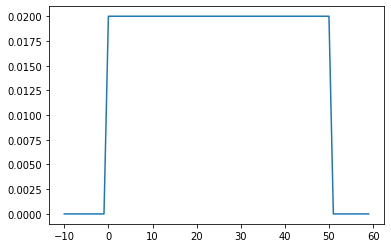

In [12]:
plt.plot(range(-10,60),[stats.uniform(0,50).pdf(x) for x in range(-10,60)])

Model's assumption on the mean height, not each individuals' height

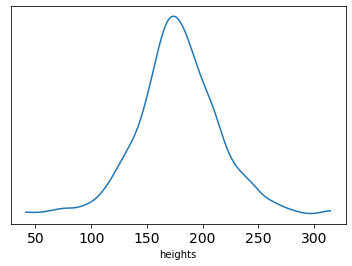

In [13]:
n_samples = 1000
sample_mu = stats.norm.rvs(loc=178, scale=20, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
az.plot_kde(prior_h)
plt.xlabel("heights")
plt.yticks([]);

Too flat prior on mu:

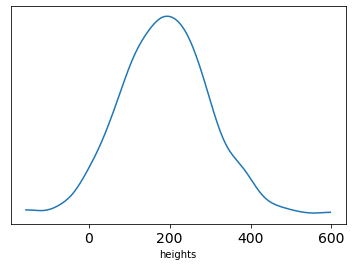

In [14]:
n_samples = 1000
sample_mu = stats.norm.rvs(loc=178, scale=100, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
az.plot_kde(prior_h)
plt.xlabel("heights")
plt.yticks([]);

The model expects giants and negative height people.

In this case due to low number of params and > data it might not make a huge difference but in other cases will.

In [15]:
with pm.Model() as model: 
        sigma = pm.Uniform('sigma', 0,50)
        mu = pm.Normal('mu', 178, 20) 
        """
        178cm with +-40 cm 1 std. 
        This shouldn't be extracted from data, but from domain knowledge!
        """
        heights = pm.Normal('height', mu, sd=sigma, observed=adults['height'])
        trace = pm.sample(progressbar=False, tune=2000)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 20 seconds.


Posterior

Text(0, 0.5, 'sigma')

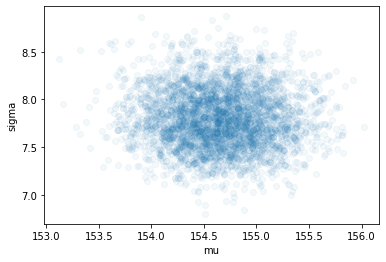

In [16]:
plt.scatter(trace['mu'], trace['sigma'], alpha=0.05)
plt.xlabel('mu')
plt.ylabel('sigma')

Marginals

(<AxesSubplot:>, array([7.21113185, 8.33617938]))

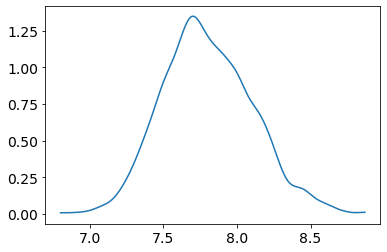

In [17]:
az.plot_kde(trace['sigma']), az.hdi(trace['sigma'])

(<AxesSubplot:>, array([153.85840631, 155.42621221]))

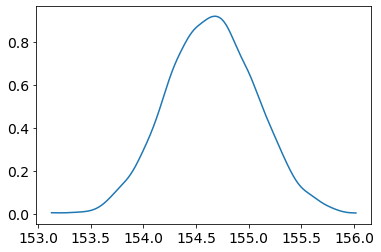

In [18]:
az.plot_kde(trace['mu']), az.hdi(trace['mu'])

Same thing but with a narrow prior

In [19]:
with pm.Model() as model: 
        sigma = pm.Uniform('sigma', 0,50)
        mu = pm.Normal('mu', 178, 0.1) 
        """
        178cm with +-40 cm 1 std. 
        This shouldn't be extracted from data, but from domain knowledge!
        """
        heights = pm.Normal('height', mu, sd=sigma, observed=adults['height'])
        trace = pm.sample(progressbar=False, tune=2000)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 19 seconds.


(<AxesSubplot:>, array([177.68402835, 178.06351483]))

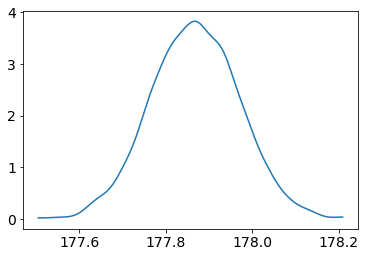

In [20]:
az.plot_kde(trace['mu']), az.hdi(trace['mu'])

(<AxesSubplot:>, array([22.64188175, 26.2486494 ]))

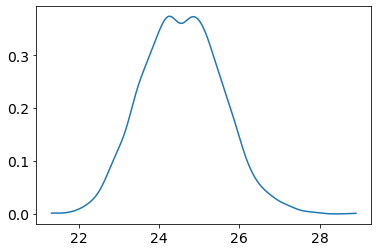

In [21]:
az.plot_kde(trace['sigma']), az.hdi(trace['sigma'])

Sigma changes drastically, although we changed mu's prior.

# Linear predictor

In [22]:
avg_weight = mean(adults['weight'])
with pm.Model() as model: 
        sigma = pm.Uniform('sigma', 0,50)
        alpha = pm.Normal('mu', 178, 20) 
        beta = pm.Normal('beta', 0, 10) 
        heights = pm.Normal('height', alpha + beta * (adults['weight'] - avg_weight), sd=sigma, observed=adults['height'])
        trace = pm.sample(progressbar=False, tune=2000)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, mu, sigma]
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 20 seconds.


# Simulating prior predictive

In [23]:
adults['weight'].describe()

count    346.000000
mean      45.045543
std        6.455220
min       31.524644
25%       40.334251
50%       45.004831
75%       49.377742
max       62.992589
Name: weight, dtype: float64

In [24]:
samples = 1000
alphas = stats.norm(178,20).rvs(samples)
betas = stats.norm(0,10).rvs(samples)

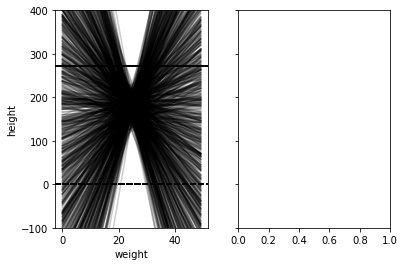

In [25]:
_, ax = plt.subplots(1, 2, sharey=True)
x=linspace(20,80)
xbar = mean(x)
for i in range(samples):
    ax[0].plot(alphas[i] + betas[i] * (x - xbar), "k", alpha=0.2)
#    ax[0].set_xlim(d2.weight.min(), d2.weight.max())
    ax[0].set_ylim(-100, 400)
    ax[0].axhline(0, c="k", ls="--")
    ax[0].axhline(272, c="k")
    ax[0].set_xlabel("weight")
    ax[0].set_ylabel("height")

In [26]:
samples = 1000
alphas = stats.norm(178,20).rvs(samples)
betas = stats.lognorm(s=1, scale=1).rvs(samples)

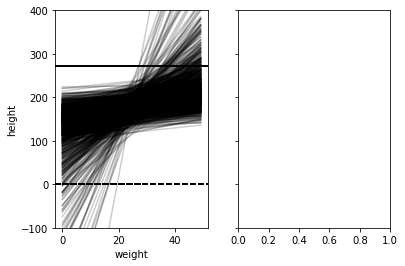

In [27]:
_, ax = plt.subplots(1, 2, sharey=True)
x=linspace(20,80)
xbar = mean(x)
for i in range(samples):
    ax[0].plot(alphas[i] + betas[i] * (x - xbar), "k", alpha=0.2)
#    ax[0].set_xlim(d2.weight.min(), d2.weight.max())
    ax[0].set_ylim(-100, 400)
    ax[0].axhline(0, c="k", ls="--")
    ax[0].axhline(272, c="k")
    ax[0].set_xlabel("weight")
    ax[0].set_ylabel("height")

It worries to me that our prior already states a positive association. It makes sense from a causal perspective, but it still feels wrong to be including it in a statistical model.

# Interpreting the posterior

In [28]:
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,154.651,0.279,154.159,155.181,0.004,0.003,5473.0,3218.0,1.0
beta,0.907,0.044,0.824,0.988,0.001,0.000,5330.0,2958.0,1.0
sigma,5.145,0.197,4.751,5.493,0.003,0.002,5632.0,3109.0,1.0


beta -> slope, typical interpretation.

In [29]:
trace_df = pm.trace_to_dataframe(trace)
trace_df.cov().round(3)

,mu,beta,sigma
mu,0.078,-0.000,0.001
beta,-0.000,0.002,-0.000
sigma,0.001,-0.000,0.039


Posterior mean -> useful for impresion of magnitude of influence

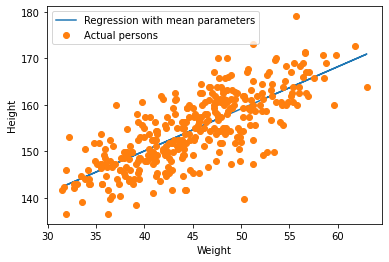

In [31]:
plt.plot(adults['weight'], mean(trace['mu']) + mean(trace['beta']) * (adults['weight']-mean(adults['weight'])), label='Regression with mean parameters')
plt.plot(adults['weight'], adults['height'], 'o', label='Actual persons')
plt.xlabel('Weight')
plt.ylabel('Height')
plt.legend()

Plotting regresion intervals and contours

Text(0.5, 0, 'Posterior height for a 50kg person')

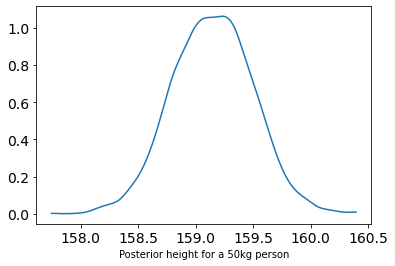

In [32]:
fifty_kg_trace = trace['mu'] + trace['beta'] * (50-mean(adults['weight']))
az.plot_kde(fifty_kg_trace)
plt.xlabel('Posterior height for a 50kg person')

In [33]:
az.hdi(fifty_kg_trace)

array([158.48478846, 159.79419108])

In [34]:
weights = linspace(adults.weight.min(), adults.weight.max())
mus = list(map(lambda x: trace['mu'] + trace['beta'] * (x-mean(adults['weight'])), weights))

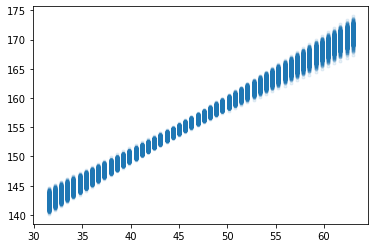

In [35]:
plt.plot(weights, mus, 'C0.', alpha=0.1)
plt.show()

In [36]:
from numpy import array
mus = array(mus)
mu_mean = mus.mean(1)
mu_hdi = az.hdi(mus.T)

/var/folders/hy/9qct0wrx5pl34rzz153ys6sw0000gp/T/ipykernel_41906/4230328703.py:4: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_hdi = az.hdi(mus.T)


In [37]:
mus.T.shape

(4000, 50)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Text(0, 0.5, 'height')

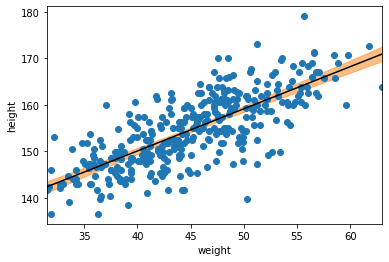

In [38]:
plt.xlim(adults.weight.min(), adults.weight.max())
az.plot_hdi(weights, mus.T)
plt.scatter(adults.weight, adults.height)
plt.plot(weights, mu_mean, "k")
plt.xlabel("weight")
plt.ylabel("height")

Remember that compatibility intervals are conditional on the model, aka given that the model is a line, this is the most plausible line and most plausible bounds.

# Prediction intervals

In [39]:
height_pred = pm.sample_posterior_predictive(trace, 200, model)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/pymc3/sampling.py:1705: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [40]:
height_pred['height'].shape

(200, 346)

In [41]:
len(adults)

346

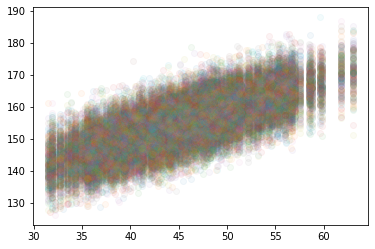

In [42]:
plt.plot(adults.weight, height_pred['height'].T, 'o', alpha=0.05)
plt.show()

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


<AxesSubplot:>

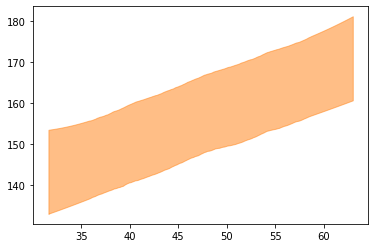

In [43]:
az.plot_hdi(adults.weight, height_pred["height"])

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


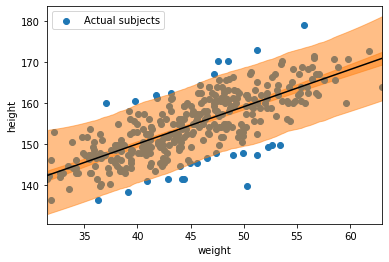

In [44]:
plt.xlim(adults.weight.min(), adults.weight.max())
az.plot_hdi(weights, mus.T)
plt.scatter(adults.weight, adults.height, label='Actual subjects')
plt.plot(weights, mu_mean, "k")
az.plot_hdi(adults.weight, height_pred["height"])
plt.xlabel("weight")
plt.ylabel("height")
plt.legend()

Posterior predictive HDI (prediction intervals), actual subjects, MAP regression line, regression line HDI (which is one type of compatibility interval).

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


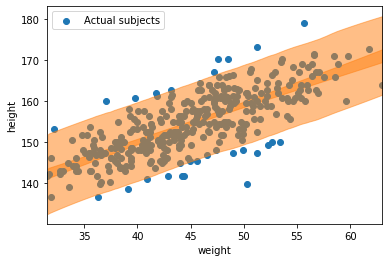

In [161]:
def plot_diagnosis(dataset, model, trace, center=True):
    if center:
        mus = array(list(map(lambda x: trace['mu'] + trace['beta'] * (x-mean(dataset['weight'])), dataset['weight'].values)))
    else:
        mus = array(list(map(lambda x: trace['mu'] + trace['beta'] * x, dataset['weight'].values)))
    height_pred = pm.sample_posterior_predictive(trace, 1000, model)
    plt.xlim(dataset.weight.min(), dataset.weight.max())
    az.plot_hdi(dataset['weight'], mus.T)
    plt.scatter(dataset.weight, dataset.height, label='Actual subjects')
#    plt.plot(weights, mean(mus), "k")
    az.plot_hdi(dataset.weight, height_pred["height"])
    plt.xlabel("weight")
    plt.ylabel("height")
    plt.legend()
    
plot_diagnosis(adults, model, trace)

Two types of uncertainty: parameter values and sampling process (when generating posterior predictive, we also add sampling from Gaussian). 

# Polynomial regression (curves from lines).

- Reinterpreting quadratic, cubic and splines regressions as probabilistic models.
- Fitting is easier than interpreting in these kinds of models.
- We won't care about overfitting for now.
- We won't care about the lack of causal explanation for now.
- Moving from adult-only to full dataset
- Another reason for standarization: overflow of powers.

In [46]:
x = (howell1.weight - mean(howell1.weight)) / std(howell1.weight)

In [47]:
with pm.Model() as linear_regression: 
        sigma = pm.Uniform('sigma', 0,50)
        alpha = pm.Normal('alpha', 178, 20)         
        beta_1 = pm.Lognormal("beta_1", mu=0, sd=1)
        mu = pm.Deterministic("mu", alpha + beta_1 * x)
        # Deterministic variable so that it's in the trace
        heights = pm.Normal('height', mu, sd=sigma, observed=howell1.height)
        linear_regression_trace = pm.sample(tune=2000)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_1, alpha, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 18 seconds.


In [48]:
x_squared = x ** 2
with pm.Model() as quadratic_regression: 
        sigma = pm.Uniform('sigma', 0,50)
        alpha = pm.Normal('alpha', 178, 20)         
        beta_1 = pm.Lognormal("beta_1", mu=0, sd=1)
        beta_2 = pm.Normal('beta_2',0,1)
        mu = pm.Deterministic("mu", alpha + beta_1 * x + beta_2 * x_squared)
        # Deterministic variable so that it's in the trace
        heights = pm.Normal('height', mu, sd=sigma, observed=howell1.height)
        quadratic_regression_trace = pm.sample(tune=2000)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_2, beta_1, alpha, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 20 seconds.


In [49]:
x_3 = x **3
with pm.Model() as cubic_regression: 
        sigma = pm.Uniform('sigma', 0,50)
        alpha = pm.Normal('alpha', 178, 20)         
        beta_1 = pm.Lognormal("beta_1", mu=0, sd=1)
        beta_2 = pm.Normal('beta_2',0,1)
        beta_3 = pm.Normal('beta_3',0,1)
        mu = pm.Deterministic("mu", alpha + beta_1 * x + beta_2 * x_squared + beta_3 * x_3)
        heights = pm.Normal('height', mu, sd=sigma, observed=howell1.height)
        cubic_regression_trace = pm.sample(tune=2000)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_3, beta_2, beta_1, alpha, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 22 seconds.


/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y,

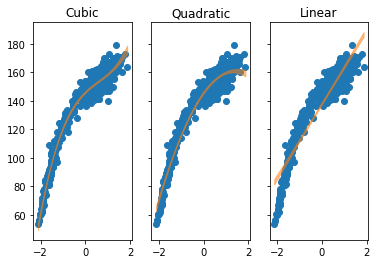

In [50]:
_, ax = plt.subplots(1, 3, sharey=True)
ax[0].scatter(x, howell1.height)
az.plot_hdi(x, cubic_regression_trace['mu'], ax=ax[0])
ax[0].title.set_text('Cubic')

ax[1].scatter(x, howell1.height)
az.plot_hdi(x, quadratic_regression_trace['mu'], ax=ax[1])
ax[1].title.set_text('Quadratic')

ax[2].scatter(x, howell1.height)
az.plot_hdi(x, linear_regression_trace['mu'], ax=ax[2])
ax[2].title.set_text('Linear')


#plt.plot(linspace(x.min(), x.max()), mean(cubic_regression_trace['alpha'])+ mean(cubic_regression_trace['beta_1'] * ) +)

# Splines

In [51]:
cherry_blossoms = pd.read_csv("data/cherry_blossoms.csv")

In [52]:
cherry_blossoms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215 entries, 0 to 1214
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        1215 non-null   int64  
 1   doy         827 non-null    float64
 2   temp        1124 non-null   float64
 3   temp_upper  1124 non-null   float64
 4   temp_lower  1124 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 47.6 KB


Categorical: prefered approach in the book is index variables (vs dummies).

In [54]:
cb = cherry_blossoms.dropna(subset=["doy"])

Text(0, 0.5, 'Day of year')

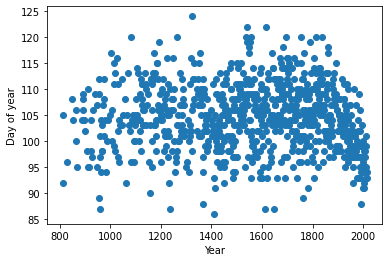

In [55]:
plt.plot(cb.year, cb.doy, 'o')
plt.xlabel('Year')
plt.ylabel('Day of year')

In [56]:
from patsy import dmatrix
from numpy import quantile

In [57]:
dmatrix

<function patsy.highlevel.dmatrix(formula_like, data={}, eval_env=0, NA_action='drop', return_type='matrix')>

In [58]:
num_knots = 15
knot_list = quantile(cb.year, linspace(0, 1, num_knots))

In [59]:
B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": cb.year.values, "knots": knot_list[1:-1]},
)

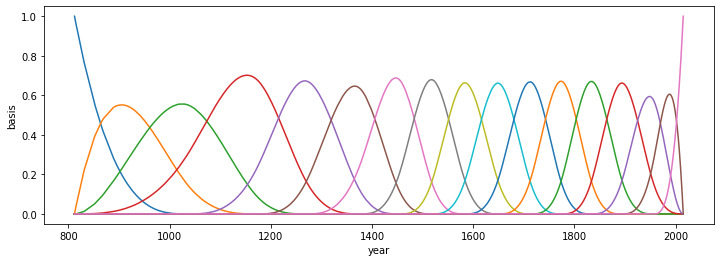

In [60]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))
for i in range(17):
    ax.plot(cb.year, (B[:, i]))
ax.set_xlabel("year")
ax.set_ylabel("basis");

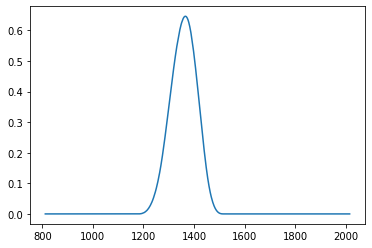

In [61]:
plt.plot(cb.year, (B[:, 5]))

# End of Chapter problems

## 4M7

In [62]:
avg_weight = mean(adults['weight'])
with pm.Model() as model_with_centering: 
        sigma = pm.Uniform('sigma', 0,50)
        alpha = pm.Normal('mu', 178, 20) 
        beta = pm.Normal('beta', 0, 10) 
        heights = pm.Normal('height', alpha + beta * (adults['weight'] - avg_weight), sd=sigma, observed=adults['height'])
        trace_centering = pm.sample(progressbar=False, tune=2000)
        
with pm.Model() as model_without_centering: 
        sigma = pm.Uniform('sigma', 0,50)
        alpha = pm.Normal('mu', 178, 20) 
        beta = pm.Normal('beta', 0, 10) 
        heights = pm.Normal('height', alpha + beta * adults['weight'], sd=sigma, observed=adults['height'])
        trace_without_centering = pm.sample(progressbar=False, tune=2000)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, mu, sigma]
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 18 seconds.
/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sam

Interpreting the parameters: with centering, intercept represents height at the mean weight, whereas with non-centering it
represents height at cero weight. Intuitively, since there are no points with zero heights, and potentially many points
around the mean value, the uncertainty of estimating alpha in each case is going to be highly different.

In [70]:
trace_without_centering.varnames

['sigma_interval__', 'mu', 'beta', 'sigma']

In [84]:
from numpy import cov, set_printoptions
set_printoptions(precision=3)
cov_without_centering = cov([trace_without_centering['mu'],trace_without_centering['beta'], trace_without_centering['sigma']])
cov_with_centering = cov([trace_centering['mu'],trace_centering['beta'], trace_centering['sigma']])

In [85]:
cov_without_centering-cov_with_centering

array([[ 3.793e+00, -8.412e-02,  1.218e-02],
       [-8.412e-02,  1.836e-05, -4.540e-04],
       [ 1.218e-02, -4.540e-04, -3.780e-04]])

In [86]:
cov_without_centering,cov_with_centering

(array([[ 3.874e+00, -8.430e-02,  1.127e-02],
        [-8.430e-02,  1.870e-03, -2.298e-04],
        [ 1.127e-02, -2.298e-04,  3.995e-02]]),
 array([[ 0.081, -0.   , -0.001],
        [-0.   ,  0.002,  0.   ],
        [-0.001,  0.   ,  0.04 ]]))

<AxesSubplot:>

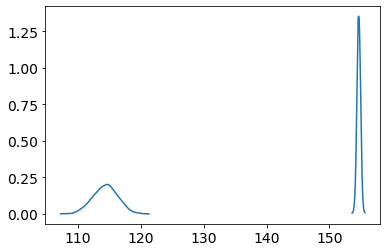

In [88]:
az.plot_kde(trace_without_centering['mu'])
az.plot_kde(trace_centering['mu'])

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/pymc3/sampling.py:1705: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


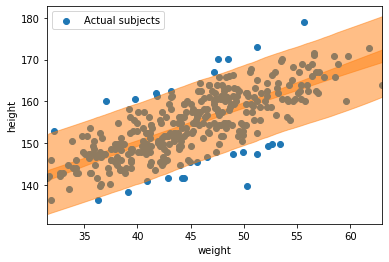

In [153]:
plot_diagnosis(adults, model_with_centering, trace_centering)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/pymc3/sampling.py:1705: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


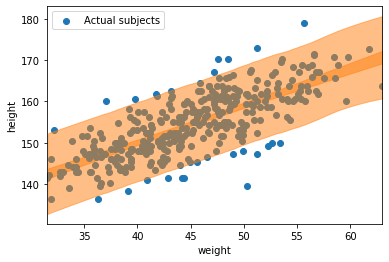

In [152]:
plot_diagnosis(adults, model_without_centering, trace_without_centering, False)

Although I am not overlapping the plots, predictions are the same, in conclussion, it's a parameter interpretation difference.

## 4H1

In [106]:
new_subjects = pd.DataFrame({'weight':[46.95, 43.72, 64.78, 32.59, 54.63]})

In [130]:
new_subjects['interval'] = new_subjects['weight'].apply(lambda weight: az.hdi(stats.norm(weight * trace_without_centering['beta'] + trace_without_centering['mu'], trace_without_centering['sigma']).rvs()))
new_subjects['expected_height'] = new_subjects['weight'].apply(lambda weight: mean(stats.norm(weight * trace_without_centering['beta'] + trace_without_centering['mu'], trace_without_centering['sigma']).rvs()))
new_subjects['expected_height_another_way'] = new_subjects['weight'].apply(lambda weight: weight * mean(trace_without_centering['beta']) + mean(trace_without_centering['mu']))

In [131]:
new_subjects.head()

,weight,interval,expected_height,expected_height_another_way
0,46.95,"[146.63974956572366, 165.89807452080979]",156.391136,156.354959
1,43.72,"[143.44124198131985, 162.8873006064416]",153.460208,153.468358
2,64.78,"[162.24391245977267, 181.83500858227492]",172.344959,172.289356
3,32.59,"[133.68247138155982, 153.46568508894404]",143.635847,143.521648
4,54.63,"[153.60730973232222, 172.92294946172387]",163.135572,163.218457


## 4H2

In [137]:
kids = howell1[howell1['age']<18]

Text(0, 0.5, 'height')

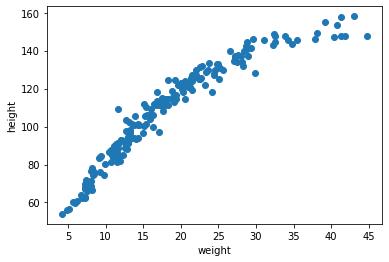

In [138]:
#plt.xlim(adults.weight.min(), adults.weight.max())
#az.plot_hdi(weights, mus.T)
plt.scatter(kids.weight, kids.height)
#plt.plot(weights, mu_mean, "k")
plt.xlabel("weight")
plt.ylabel("height")

In [139]:
with pm.Model() as kids_wo_centering: 
        sigma = pm.Uniform('sigma', 0,50)
        alpha = pm.Normal('mu', 178, 20) 
        beta = pm.Normal('beta', 0, 10) 
        heights = pm.Normal('height', alpha + beta * kids['weight'], sd=sigma, observed=kids['height'])
        trace_kids_wo_centering = pm.sample(progressbar=False, tune=2000)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, mu, sigma]
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 20 seconds.


In [140]:
trace_kids_wo_centering

<MultiTrace: 4 chains, 1000 iterations, 4 variables>

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/pymc3/sampling.py:1705: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


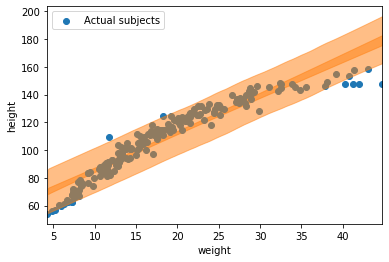

In [162]:
plot_diagnosis(kids, kids_wo_centering, trace_kids_wo_centering, False)

- The model does a bad job at very low weights (newborns?) and very high weights (near 18, where they are almost adults and don't grow that much).
- Prediction intervals are to wide (>20 cm).                                                                                
- alpha = pm.Normal('mu', 178, 20)` seems like an unreasonable prior (based on domain knowledge, not data!). We shouldn't set priors based on data, just pointing out that the choice of prior affects here.

## 4H3

In [173]:
center = mean(log(dataset['weight'].values))
with pm.Model() as full_log_model: 
        sigma = pm.Uniform('sigma', 0,50)
        alpha = pm.Normal('mu', 178, 20) 
        beta = pm.Normal('beta', 0, 10) 
        heights = pm.Normal('height', alpha + beta * (log(howell1['weight']) - center), sd=sigma, observed=howell1['height'])
        trace_full_log_model = pm.sample(progressbar=False, tune=5000)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, mu, sigma]
Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 21 seconds.


/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/pymc3/sampling.py:1705: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


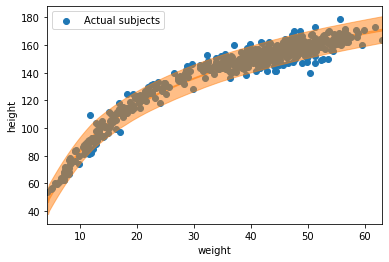

In [174]:
    dataset=howell1
    model=full_log_model
    trace=trace_full_log_model
    mus = array(list(map(lambda x: trace['mu'] + trace['beta'] * (log(x) - center), dataset['weight'].values)))
    height_pred = pm.sample_posterior_predictive(trace, 1000, model)
    plt.xlim(dataset.weight.min(), dataset.weight.max())
    az.plot_hdi(dataset['weight'], mus.T)
    plt.scatter(dataset.weight, dataset.height, label='Actual subjects')
#    plt.plot(weights, mean(mus), "k")
    az.plot_hdi(dataset.weight, height_pred["height"])
    plt.xlabel("weight")
    plt.ylabel("height")
    plt.legend()
    